# Policy iteration

In [ ]:
!pip install gymnasium

In [ ]:
import random

import numpy as np
import gymnasium as gym
import time
from gymnasium import spaces
import os


# custom 2d grid world enviroment
class GridWorld(gym.Env):
    metadata = {'render.modes': ['console']}

    # actions available
    UP = 0
    LEFT = 1
    DOWN = 2
    RIGHT = 3


    def __init__(self, width, height):
        super(GridWorld, self).__init__()
        self.ACTION_NAMES = ["UP", "LEFT", "DOWN", "RIGHT"]
        self.num_actions = 4

        self.size = width * height  # size of the grid world
        self.num_states = self.size
        self.width = width
        self.height = height
        self.num_obstacles = int((width+height)/2)
        self.end_state = np.array([height - 1, width - 1], dtype=np.uint8) # goal state = bottom right cell

        # actions of agents : up, down, left and right
        self.action_space = spaces.Discrete(4)
        # observation : cell indices in the grid
        self.observation_space = spaces.MultiDiscrete([self.height, self.width])

        self.obstacles = np.zeros((height, width))

        for i in range(self.num_obstacles):
            self.obstacles[ random.randrange(height) , random.randrange(width)] = 1

        self.num_steps = 0
        self.max_steps = height*width

        self.current_state = np.zeros((2), np.uint8)#init state = [0,0]

        self.directions = np.array([
            [-1,0], #UP
            [0,-1], #LEFT
            [1,0], #DOWN
            [0,1] #RIGHT
        ])

    def transition_function(self, s, a):
        s_prime = s + self.directions[a,:]

        if s_prime[0] < self.height and s_prime[1] < self.width and (s_prime >= 0).all():
            if self.obstacles[s_prime[0], s_prime[1]] == 0 :
                return s_prime

        return s

    def transition_probabilities(self, s, a):
        prob_next_state = np.zeros((self.heigth, self.width))
        s_prime = self.transition_function(s, a)

        prob_next_state[s_prime[0], s_prime[1]] = 1.0

        return prob_next_state#.flatten()

    def reward_function(self,s):
        r = 0.0
        if (s == self.end_state).all():
            r = 1

        return r

    def termination_condition(self, s):

        terminated = (s == self.end_state).all()
        truncated = self.num_steps > self.max_steps

        return terminated, truncated

    def step(self, action):
        s_prime = self.transition_function(self.current_state, action)
        reward = self.reward_function(s_prime)
        terminated, truncated = self.termination_condition(s_prime)

        self.current_state = s_prime
        self.num_steps += 1

        return self.current_state, reward, terminated, truncated, None

    def render(self):
        '''
            render the state
        '''

        row = self.current_state[0]
        col = self.current_state[1]

        for r in range(self.height):
            for c in range(self.width):
                if r == row and c == col:
                    print("| A ", end='')
                elif r == self.end_state[0] and c == self.end_state[1]:
                    print("| G ", end='')
                else:
                    if self.obstacles[r,c] == 1:
                        print('|///', end='')
                    else:
                        print('|___', end='')
            print('|')
        print('\n')



    def reset(self):
        self.current_state = np.zeros((2), np.uint8)
        self.num_steps = 0
        return self.current_state

    def reward_probabilities(self):
        rewards = np.zeros((self.num_states))
        i = 0
        for r in range(self.height):
            for c in range(self.width):
                state = np.array([r,c], dtype=np.uint8)
                rewards[i] = self.reward_function(state)
                i+=1

        return rewards

    def close(self):
        pass


class NonDeterministicGridWorld(GridWorld):
    def __init__(self, width, height, p=0.8):
        super(NonDeterministicGridWorld, self).__init__(width, height)
        self.probability_right_action = p

    def transition_function(self, s, a):
        s_prime = s + self.directions[a, :]

        #with probability 1 - p diagonal movement
        if random.random() <= 1 - self.probability_right_action:
            if random.random() < 0.5:
                s_prime = s_prime + self.directions[(a+1)%self.num_actions, :]
            else:
                s_prime = s_prime + self.directions[(a-1)%self.num_actions, :]


        if s_prime[0] < self.height and s_prime[1] < self.width and (s_prime >= 0).all():
            if self.obstacles[s_prime[0], s_prime[1]] == 0 :
                return s_prime

        return s

    def transition_probabilities(self, s, a):
        cells = []
        probs = []
        prob_next_state = np.zeros((self.height, self.width))
        s_prime_right =  s + self.directions[a, :]
        if s_prime_right[0] < self.height and s_prime_right[1] < self.width and (s_prime_right >= 0).all():
            if self.obstacles[s_prime_right[0], s_prime_right[1]] == 0 :
                prob_next_state[s_prime_right[0], s_prime_right[1]] = self.probability_right_action
                cells.append(s_prime_right)
                probs.append(self.probability_right_action)

        s_prime = s_prime_right + self.directions[(a + 1) % self.num_actions, :]
        if s_prime[0] < self.height and s_prime[1] < self.width and (s_prime >= 0).all():
            if self.obstacles[s_prime[0], s_prime[1]] == 0 :
                prob_next_state[s_prime[0], s_prime[1]] = (1 - self.probability_right_action) / 2
                cells.append(s_prime.copy())
                probs.append((1 - self.probability_right_action) / 2)

        s_prime = s_prime_right + self.directions[(a - 1) % self.num_actions, :]
        if s_prime[0] < self.height and s_prime[1] < self.width and (s_prime >= 0).all():
            if self.obstacles[s_prime[0], s_prime[1]] == 0 :
                prob_next_state[s_prime[0], s_prime[1]] = (1 - self.probability_right_action) / 2
                cells.append(s_prime.copy())
                probs.append((1 - self.probability_right_action) / 2)

        #normalization
        sump = sum(probs)
        #for cell in cells:
        #    prob_next_state[cell[0], cell[1]] /= sump
        prob_next_state[s[0], s[1]] = 1 - sump
        return prob_next_state


To apply policy iteration we need the **transition probabilities** and the **reward function**

Print the probability over the next state

In [ ]:
env = NonDeterministicGridWorld(3,5)
state = env.reset()
env.render()
#next state if we start from state 0,0 and we do action down
next_state_prob = env.transition_probabilities(state, 2)
print(next_state_prob)

reward values

In [ ]:
print(env.reward_probabilities())


# Policy iteration algorithm

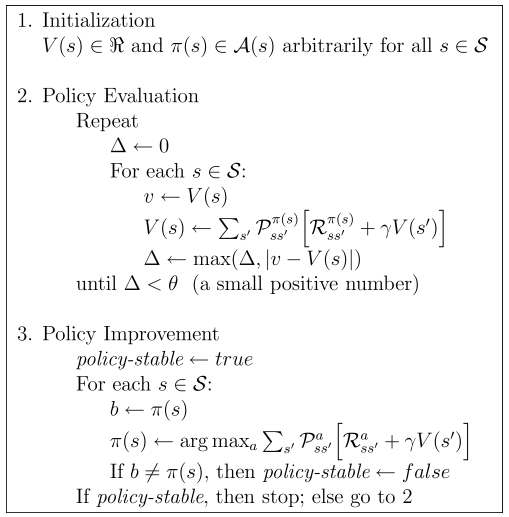

![](imgs/value_iteration.png)

In [ ]:
def policy_iteration(env, gamma=0.99, max_iters=100, theta=1e-3):
    # rename to policy
    policy = np.random.randint(0, env.num_actions, (env.num_states))
    print(policy)
    values = np.random.random((env.num_states))
    STATES = np.zeros((env.num_states, 2), dtype=np.uint8)
    REWARDS = env.reward_probabilities()
    print(REWARDS)
    i = 0
    for r in range(env.height):
        for c in range(env.width):
            state = np.array([r, c], dtype=np.uint8)
            STATES[i] = state
            i += 1
    for i in range(max_iters):
        # policy evaluation
        while True:
          delta = 0
          for s in range(env.num_states):
              state = STATES[s]
              v_old = values[s]
              # deterministic policy, so no need for weighted sum over actions
              a = policy[s]
              next_state_prob = env.transition_probabilities(state, a).flatten()
              done = (state == env.end_state).all()
              # TODO complete the update rules
              values[s] = ...
              delta = ...
          if delta < theta:
              break
        # policy improvement
        policy_stable = True
        old_policy = policy.copy()
        for s in range(env.num_states):
            state = STATES[s]
            b = policy[s] # save old best action
            # compute new best action based on the updated value
            best_value = -float('inf')
            best_action = None
            for a in range(env.num_actions):
                next_state_prob = env.transition_probabilities(state, a).flatten()
                # TODO complete the update rule
                va = ...
                if va > best_value:
                    best_value = va
                    best_action = a
            policy[s] = best_action
            if best_action != b:
                policy_stable = False
        if policy_stable:
            break
    print(f'finished in {i+1} iterations')
    return policy.reshape((env.height, env.width)), values.reshape((env.height, env.width))

perform policy iteration

In [ ]:
best_actions, values = policy_iteration(env)

print(best_actions)
print(values)

simulate optimal policy


In [ ]:
done = False
state = env.reset()
while not done:
    action = best_actions[state[0],state[1]]

    state, reward, terminated, truncated, _ = env.step(action)
    done = terminated or truncated
    env.render()
